In [1]:
%load_ext pretty_jupyter

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

from datetime import date
import hisepy
import numpy as np
import os
import pandas as pd
import re
import scanpy as sc

## Helper functions

In [3]:
def cache_uuid_path(uuid):
    cache_path = '/home/jupyter/cache/{u}'.format(u = uuid)
    if not os.path.isdir(cache_path):
        hise_res = hisepy.reader.cache_files([uuid])
    filename = os.listdir(cache_path)[0]
    cache_file = '{p}/{f}'.format(p = cache_path, f = filename)
    return cache_file

In [4]:
def read_csv_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = pd.read_csv(cache_file)
    return res

In [5]:
def read_parquet_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = pd.read_parquet(cache_file)
    return res

In [6]:
def read_adata_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = sc.read_h5ad(cache_file)
    return res

In [7]:
def backed_adata_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = sc.read_h5ad(cache_file, backed = 'r')
    return res

In [8]:
def rm_cache_uuid(uuid):
    cache_path = '/home/jupyter/cache/{u}'.format(u = uuid)
    rm_call = 'rm -r {d}'.format(d = cache_path)
    os.system(rm_call)

In [9]:
def format_cell_type(cell_type):
    cell_type = re.sub('\\+', 'pos', cell_type)
    cell_type = re.sub('-', 'neg', cell_type)
    cell_type = re.sub(' ', '_', cell_type)
    return cell_type

In [10]:
def filename_cell_type(filename):
    cell_type = re.sub('.+L3_','',filename)
    cell_type = re.sub('_2024.+','',cell_type)
    cell_type = re.sub('_', ' ', cell_type)
    cell_type = re.sub('pos','+', cell_type)
    cell_type = re.sub('neg','-', cell_type)
    return cell_type

In [11]:
def add_labels(adata, labels):
    obs = adata.obs
    obs = obs.reset_index(drop = True)
    obs = obs.merge(labels, on = 'barcodes', how = 'left')
    obs = obs.set_index('barcodes', drop = False)
    adata.obs = obs
    return adata

In [12]:
def element_id(n = 3):
    import periodictable
    from random import randrange
    rand_el = []
    for i in range(n):
        el = randrange(0,118)
        rand_el.append(periodictable.elements[el].name)
    rand_str = '-'.join(rand_el)
    return rand_str

## Markers for dotplots

In [13]:
broad_markers = [
    'CD3D', # T cells
    'CD3E', # T cells/NK
    'FCN1', # Monocytes/Myeloid
    'HBB', # Erythrocytes
    'IL7R', # T cells
    'MS4A1', # B cells
    'CD79A', # B cells
    'PPBP', # Platelets
    'IFI44L' # ISG-high
]

In [14]:
class_markers = [
    'FCGR3A', # CD16+ cells
    'GZMB',
    'GZMK',   # GZMK+ (between CD56hi and CD56dim)
    'IFI44L', # ISG-high
    'NCAM1',  # CD56
    'PTMS'    # Some adaptive NK
]

## Read previous, non-tracked labels
We ran a preliminary analysis of our dataset that wasn't tracked for reproducibility. Here, we'll retrieve the labels for visualization and comparison to check for consistency.

In [15]:
original_uuid = '3868592c-0087-4ed8-98b2-4bf1b8676111'
original_df = read_parquet_uuid(original_uuid)
original_df = original_df[['barcodes', 'AIFI_L1', 'AIFI_L2', 'AIFI_L3']]
original_df = original_df.rename({'AIFI_L1': 'original_L1', 'AIFI_L2': 'original_L2', 'AIFI_L3': 'original_L3'}, axis = 1)

In [16]:
original_df.head()

barcodes original_L1 original_L2 original_L3
0  05ea9806794211eb93b836d1cb6129eb          DC        cDC1        cDC1
1  e225c914794011eb9282e2ceeb91ba52          DC        cDC1        cDC1
2  b1379eae795411eb958b0245821e6993          DC        cDC1        cDC1
3  b13d3a8a795411eb958b0245821e6993          DC        cDC1        cDC1
4  b1430d16795411eb958b0245821e6993          DC        cDC1        cDC1

## Read cell type hierarchy

In [17]:
hierarchy_uuid = '1a44252c-8cab-4c8f-92c9-d8f3af633790'
hierarchy_df = read_csv_uuid(hierarchy_uuid)

## Identify files for use in HISE

In [18]:
search_id = 'livermorium-copper-curium'

Retrieve files stored in our HISE project store

In [19]:
ps_df = hisepy.list_files_in_project_store('cohorts')
ps_df = ps_df[['id', 'name']]

Filter for files from the previous notebook using our search_id

In [20]:
search_df = ps_df[ps_df['name'].str.contains(search_id)]
search_df = search_df.sort_values('name')
search_df['AIFI_L3'] = [filename_cell_type(f) for f in search_df['name']]

In [21]:
search_df['AIFI_L3'].tolist()

['Adaptive NK cell',
 'CD56bright NK cell',
 'GZMK- CD56dim NK cell',
 'GZMK+ CD56dim NK cell',
 'ILC',
 'ISG+ CD56dim NK cell',
 'NK reasons',
 'Proliferating NK cell']

## Review Adaptive NK cell

In [22]:
cell_type = 'Adaptive NK cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [23]:
type_uuid

'9510726c-2d47-4285-9927-91b03734a98c'

In [24]:
adata = read_adata_uuid(type_uuid)

### Clustering

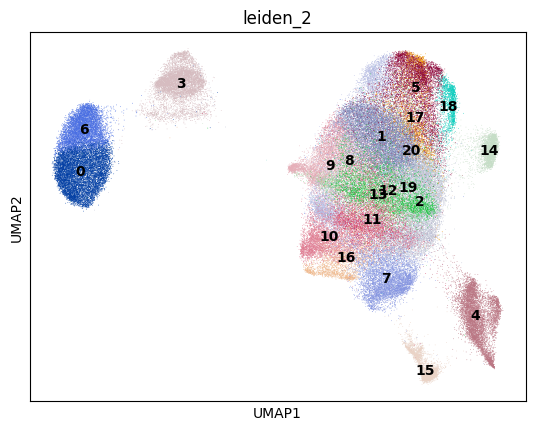

In [25]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Marker expression

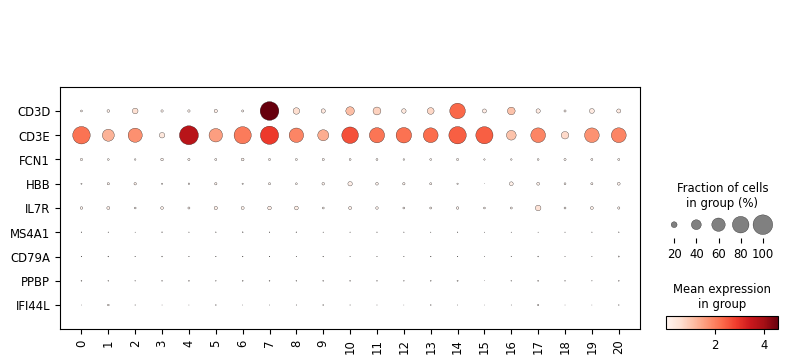

In [26]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

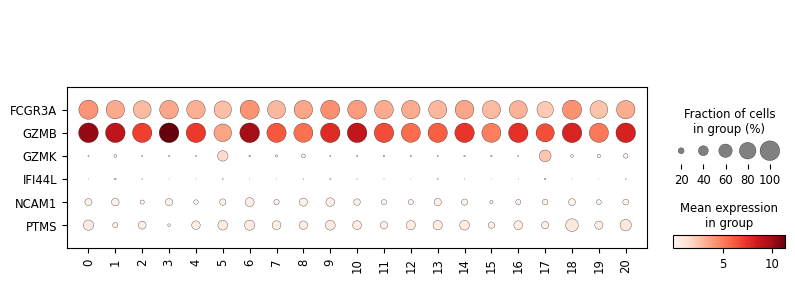

In [27]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = class_markers, swap_axes = True)

### Cluster counts

In [28]:
adata.obs['leiden_2'].value_counts()

leiden_2
0     9311
1     9108
2     8291
3     7504
4     7228
5     6334
6     6261
7     6144
8     5557
9     5445
10    5252
11    4732
12    3807
13    3600
14    3148
15    3069
16    2893
17    2341
18    2027
19     896
20     228
Name: count, dtype: int64

### Comparison to original labels

In [29]:
adata = add_labels(adata, original_df)

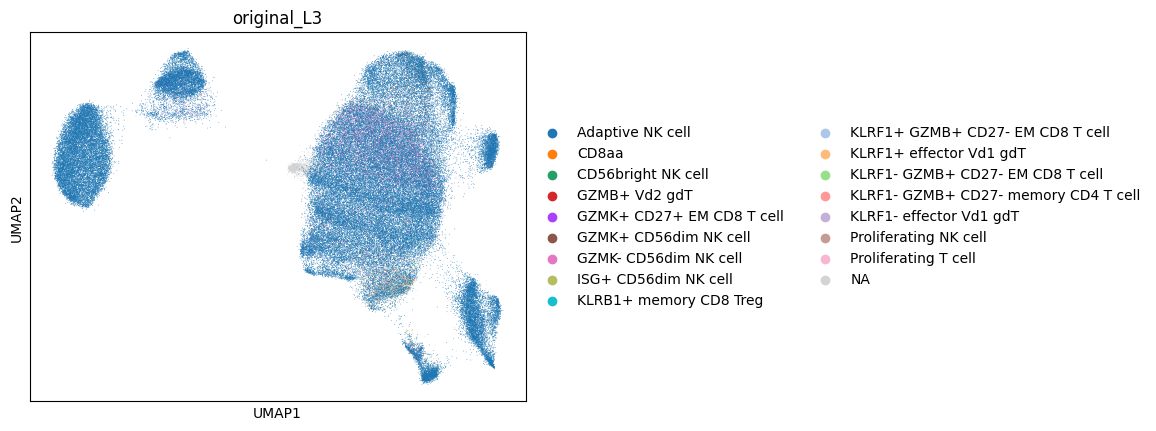

In [30]:
sc.pl.umap(adata, color = 'original_L3')

In [31]:
adata.obs['original_L3'].value_counts(dropna = False)

original_L3
Adaptive NK cell                        92968
GZMK- CD56dim NK cell                    4075
NaN                                      3118
KLRF1+ effector Vd1 gdT                   876
KLRF1- GZMB+ CD27- EM CD8 T cell          534
KLRF1- effector Vd1 gdT                   401
GZMK+ CD56dim NK cell                     356
GZMB+ Vd2 gdT                             286
KLRF1+ GZMB+ CD27- EM CD8 T cell          236
CD56bright NK cell                        156
ISG+ CD56dim NK cell                       86
Proliferating NK cell                      51
KLRF1- GZMB+ CD27- memory CD4 T cell       20
CD8aa                                       6
GZMK+ CD27+ EM CD8 T cell                   3
Proliferating T cell                        3
KLRB1+ memory CD8 Treg                      1
Name: count, dtype: int64

In [32]:
adata.obs['original_L3'].value_counts(dropna = False) / adata.obs.shape[0]

original_L3
Adaptive NK cell                        0.901062
GZMK- CD56dim NK cell                   0.039496
NaN                                     0.030220
KLRF1+ effector Vd1 gdT                 0.008490
KLRF1- GZMB+ CD27- EM CD8 T cell        0.005176
KLRF1- effector Vd1 gdT                 0.003887
GZMK+ CD56dim NK cell                   0.003450
GZMB+ Vd2 gdT                           0.002772
KLRF1+ GZMB+ CD27- EM CD8 T cell        0.002287
CD56bright NK cell                      0.001512
ISG+ CD56dim NK cell                    0.000834
Proliferating NK cell                   0.000494
KLRF1- GZMB+ CD27- memory CD4 T cell    0.000194
CD8aa                                   0.000058
GZMK+ CD27+ EM CD8 T cell               0.000029
Proliferating T cell                    0.000029
KLRB1+ memory CD8 Treg                  0.000010
Name: count, dtype: float64

## Review CD56bright NK cell

In [33]:
cell_type = 'CD56bright NK cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [34]:
type_uuid

'f2154cb9-7694-4f2d-bf45-dda172fb1279'

In [35]:
adata = read_adata_uuid(type_uuid)

### Clustering

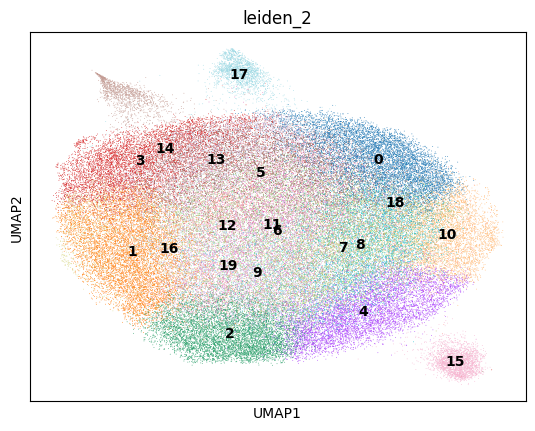

In [36]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Marker expression

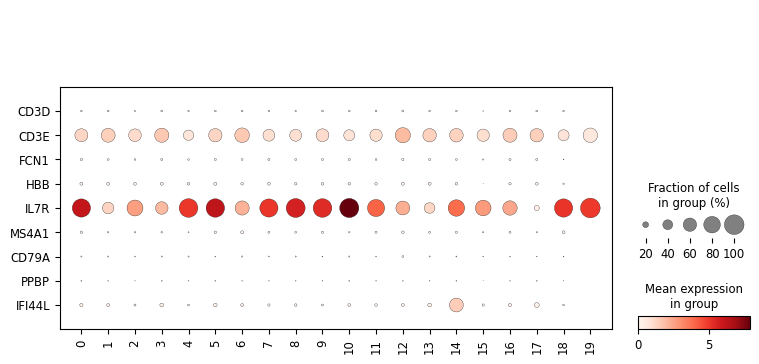

In [37]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

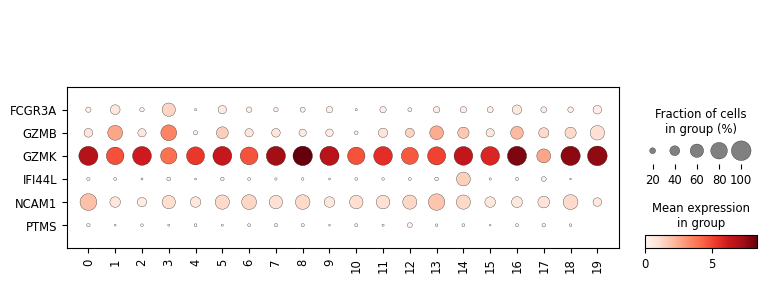

In [38]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = class_markers, swap_axes = True)

### Cluster counts

In [39]:
adata.obs['leiden_2'].value_counts()

leiden_2
0     7450
1     7403
2     6704
3     6469
4     6236
5     6067
6     5824
7     5642
8     4911
9     4465
10    4253
11    4179
12    3400
13    3342
14    3183
15    2648
16    2437
17    2355
18     129
19       3
Name: count, dtype: int64

### Comparison to original labels

In [40]:
adata = add_labels(adata, original_df)

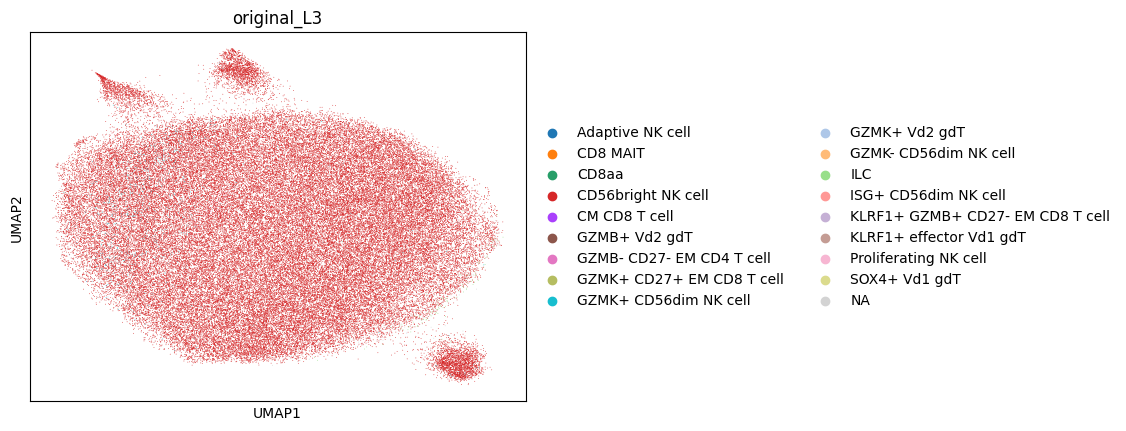

In [41]:
sc.pl.umap(adata, color = 'original_L3')

In [42]:
adata.obs['original_L3'].value_counts(dropna = False)

original_L3
CD56bright NK cell                  85374
GZMK+ CD56dim NK cell                 709
NaN                                   636
Proliferating NK cell                 160
ILC                                   124
ISG+ CD56dim NK cell                   32
GZMK+ Vd2 gdT                          16
Adaptive NK cell                       14
GZMK- CD56dim NK cell                  12
CD8aa                                   8
GZMB+ Vd2 gdT                           4
KLRF1+ effector Vd1 gdT                 3
CD8 MAIT                                2
SOX4+ Vd1 gdT                           2
GZMK+ CD27+ EM CD8 T cell               1
GZMB- CD27- EM CD4 T cell               1
CM CD8 T cell                           1
KLRF1+ GZMB+ CD27- EM CD8 T cell        1
Name: count, dtype: int64

In [43]:
adata.obs['original_L3'].value_counts(dropna = False) / adata.obs.shape[0]

original_L3
CD56bright NK cell                  0.980184
GZMK+ CD56dim NK cell               0.008140
NaN                                 0.007302
Proliferating NK cell               0.001837
ILC                                 0.001424
ISG+ CD56dim NK cell                0.000367
GZMK+ Vd2 gdT                       0.000184
Adaptive NK cell                    0.000161
GZMK- CD56dim NK cell               0.000138
CD8aa                               0.000092
GZMB+ Vd2 gdT                       0.000046
KLRF1+ effector Vd1 gdT             0.000034
CD8 MAIT                            0.000023
SOX4+ Vd1 gdT                       0.000023
GZMK+ CD27+ EM CD8 T cell           0.000011
GZMB- CD27- EM CD4 T cell           0.000011
CM CD8 T cell                       0.000011
KLRF1+ GZMB+ CD27- EM CD8 T cell    0.000011
Name: count, dtype: float64

## Review GZMK- CD56dim NK cell

In [44]:
cell_type = 'GZMK- CD56dim NK cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [45]:
type_uuid

'd4109a83-200d-4fb6-83ca-d0b0b306c866'

In [46]:
adata = read_adata_uuid(type_uuid)

### Clustering

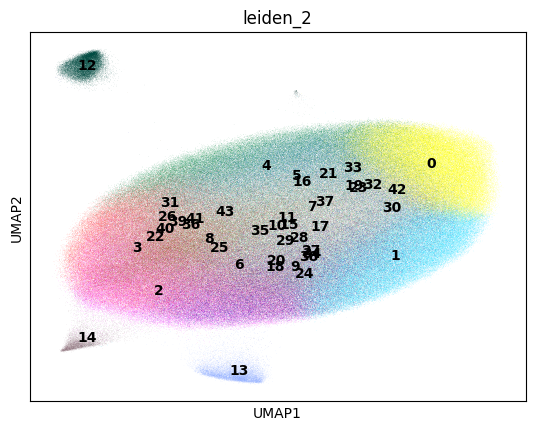

In [47]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Marker expression

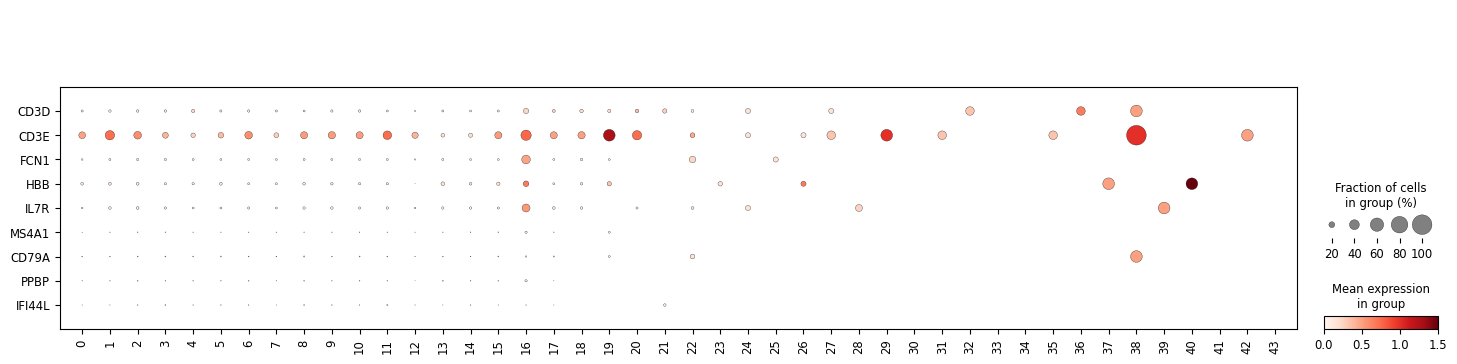

In [48]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

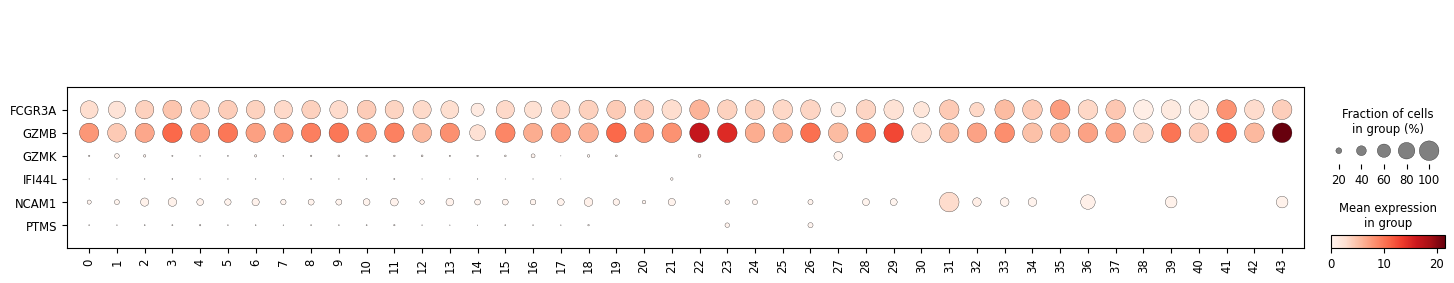

In [49]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = class_markers, swap_axes = True)

### Cluster counts

In [50]:
adata.obs['leiden_2'].value_counts()

leiden_2
0     93149
1     79760
2     70874
3     64900
4     61349
5     59615
6     54971
7     53856
8     52980
9     50799
10    50329
11    45556
12    22836
13    16240
14     9688
15     2219
16      533
17      177
18       30
19       22
20       19
21       15
22       13
23        7
25        6
26        6
27        6
24        6
28        4
29        4
30        4
34        3
36        3
35        3
33        3
32        3
31        3
37        2
38        2
39        2
40        2
41        2
42        2
43        2
Name: count, dtype: int64

### Comparison to original labels

In [51]:
adata = add_labels(adata, original_df)

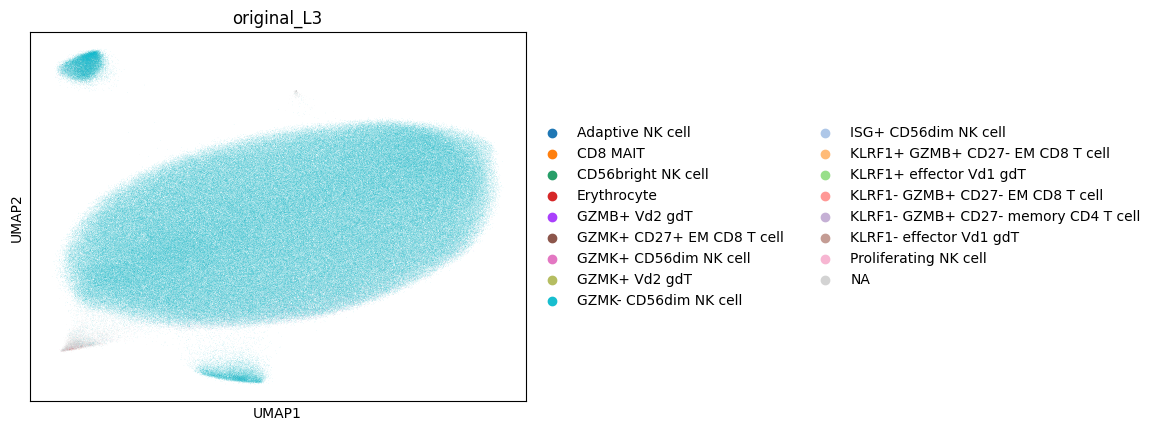

In [52]:
sc.pl.umap(adata, color = 'original_L3')

In [53]:
adata.obs['original_L3'].value_counts(dropna = False)

original_L3
GZMK- CD56dim NK cell                   748747
NaN                                      26433
GZMK+ CD56dim NK cell                     5411
Adaptive NK cell                          5350
ISG+ CD56dim NK cell                      2829
Proliferating NK cell                      627
CD56bright NK cell                         211
GZMB+ Vd2 gdT                              200
Erythrocyte                                 83
KLRF1+ effector Vd1 gdT                     43
KLRF1- GZMB+ CD27- EM CD8 T cell            30
CD8 MAIT                                    13
KLRF1- effector Vd1 gdT                     12
KLRF1+ GZMB+ CD27- EM CD8 T cell             9
GZMK+ Vd2 gdT                                4
KLRF1- GZMB+ CD27- memory CD4 T cell         2
GZMK+ CD27+ EM CD8 T cell                    1
Name: count, dtype: int64

In [54]:
adata.obs['original_L3'].value_counts(dropna = False) / adata.obs.shape[0]

original_L3
GZMK- CD56dim NK cell                   0.947775
NaN                                     0.033459
GZMK+ CD56dim NK cell                   0.006849
Adaptive NK cell                        0.006772
ISG+ CD56dim NK cell                    0.003581
Proliferating NK cell                   0.000794
CD56bright NK cell                      0.000267
GZMB+ Vd2 gdT                           0.000253
Erythrocyte                             0.000105
KLRF1+ effector Vd1 gdT                 0.000054
KLRF1- GZMB+ CD27- EM CD8 T cell        0.000038
CD8 MAIT                                0.000016
KLRF1- effector Vd1 gdT                 0.000015
KLRF1+ GZMB+ CD27- EM CD8 T cell        0.000011
GZMK+ Vd2 gdT                           0.000005
KLRF1- GZMB+ CD27- memory CD4 T cell    0.000003
GZMK+ CD27+ EM CD8 T cell               0.000001
Name: count, dtype: float64

## Review GZMK+ CD56dim NK cell

In [55]:
cell_type = 'GZMK+ CD56dim NK cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [56]:
type_uuid

'bfdcbadb-97bc-49d4-b15a-2cd922eab5ee'

In [57]:
adata = read_adata_uuid(type_uuid)

### Clustering

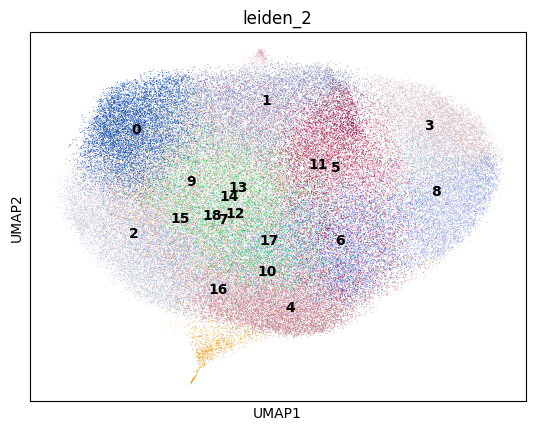

In [58]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Marker expression

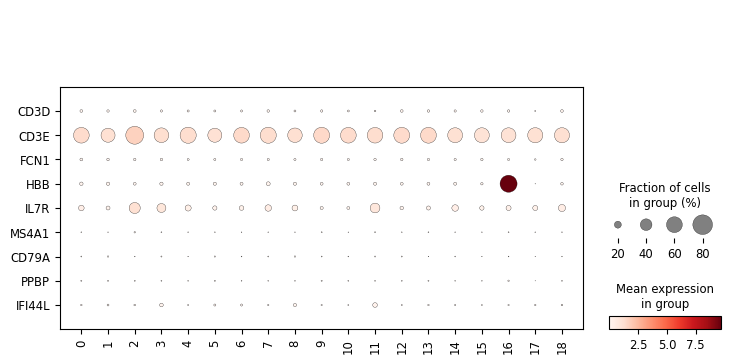

In [59]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

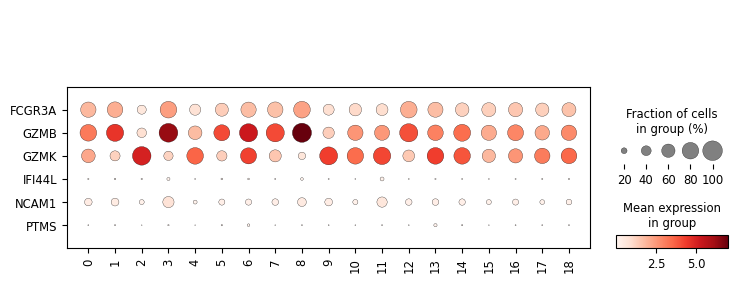

In [60]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = class_markers, swap_axes = True)

### Cluster counts

In [61]:
adata.obs['leiden_2'].value_counts()

leiden_2
0     8772
1     7643
2     7193
3     7146
4     6913
5     6412
6     5933
7     5931
8     5595
9     5308
10    5012
11    4990
12    4647
13    4302
14    3185
15    2915
16    2159
17    1945
18    1766
Name: count, dtype: int64

### Comparison to original labels

In [62]:
adata = add_labels(adata, original_df)

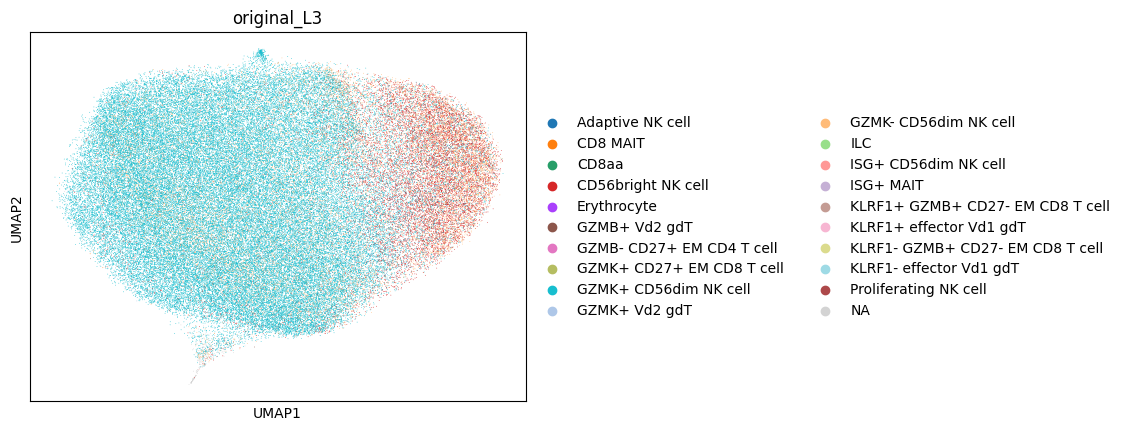

In [63]:
sc.pl.umap(adata, color = 'original_L3')

In [64]:
adata.obs['original_L3'].value_counts(dropna = False)

original_L3
GZMK+ CD56dim NK cell               71026
GZMK- CD56dim NK cell               13555
CD56bright NK cell                  10181
NaN                                  1180
Adaptive NK cell                      893
ISG+ CD56dim NK cell                  399
GZMB+ Vd2 gdT                         192
Proliferating NK cell                 147
GZMK+ Vd2 gdT                         132
KLRF1+ GZMB+ CD27- EM CD8 T cell       16
CD8 MAIT                               14
KLRF1+ effector Vd1 gdT                 8
KLRF1- GZMB+ CD27- EM CD8 T cell        7
KLRF1- effector Vd1 gdT                 6
GZMK+ CD27+ EM CD8 T cell               3
CD8aa                                   3
ILC                                     2
Erythrocyte                             1
GZMB- CD27+ EM CD4 T cell               1
ISG+ MAIT                               1
Name: count, dtype: int64

In [65]:
adata.obs['original_L3'].value_counts(dropna = False) / adata.obs.shape[0]

original_L3
GZMK+ CD56dim NK cell               0.726482
GZMK- CD56dim NK cell               0.138646
CD56bright NK cell                  0.104135
NaN                                 0.012070
Adaptive NK cell                    0.009134
ISG+ CD56dim NK cell                0.004081
GZMB+ Vd2 gdT                       0.001964
Proliferating NK cell               0.001504
GZMK+ Vd2 gdT                       0.001350
KLRF1+ GZMB+ CD27- EM CD8 T cell    0.000164
CD8 MAIT                            0.000143
KLRF1+ effector Vd1 gdT             0.000082
KLRF1- GZMB+ CD27- EM CD8 T cell    0.000072
KLRF1- effector Vd1 gdT             0.000061
GZMK+ CD27+ EM CD8 T cell           0.000031
CD8aa                               0.000031
ILC                                 0.000020
Erythrocyte                         0.000010
GZMB- CD27+ EM CD4 T cell           0.000010
ISG+ MAIT                           0.000010
Name: count, dtype: float64

## Review ISG+ CD56dim NK cell

In [66]:
cell_type = 'ISG+ CD56dim NK cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [67]:
type_uuid

'51da6180-8d06-480b-a629-33026975d320'

In [68]:
adata = read_adata_uuid(type_uuid)

### Clustering

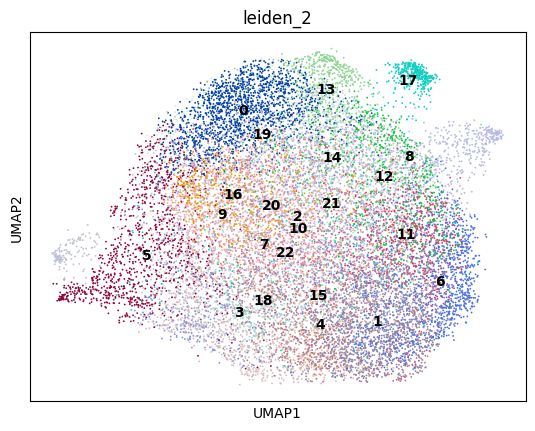

In [69]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Marker expression

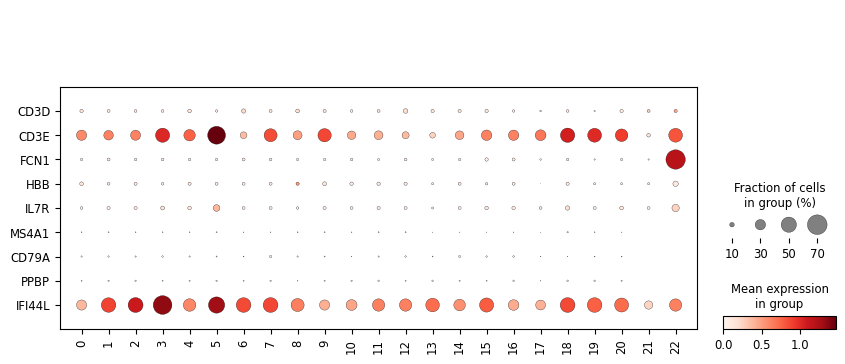

In [70]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

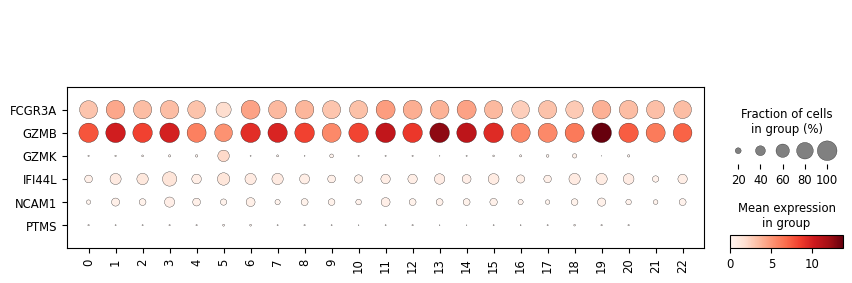

In [71]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = class_markers, swap_axes = True)

### Cluster counts

In [72]:
adata.obs['leiden_2'].value_counts()

leiden_2
0     1607
1     1364
2     1260
3     1207
4     1167
5     1100
6     1032
7      990
8      984
9      931
10     840
11     708
12     703
13     686
14     566
15     562
16     552
17     535
18     462
19     266
20     168
21      54
22      16
Name: count, dtype: int64

### Comparison to original labels

In [73]:
adata = add_labels(adata, original_df)

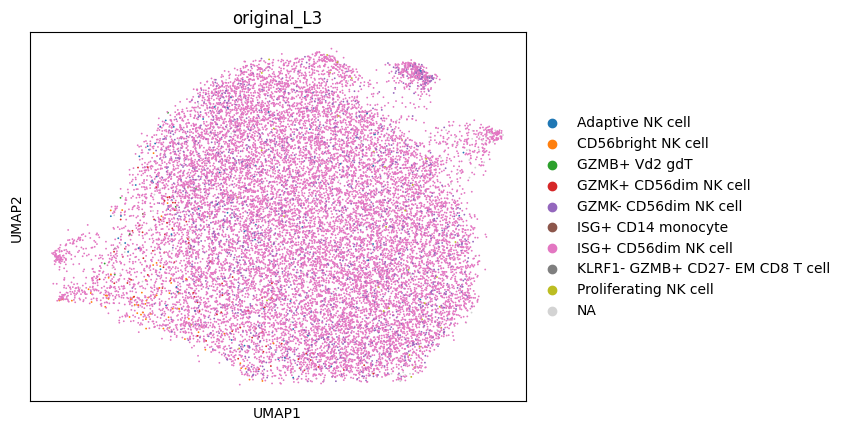

In [74]:
sc.pl.umap(adata, color = 'original_L3')

In [75]:
adata.obs['original_L3'].value_counts(dropna = False)

original_L3
ISG+ CD56dim NK cell                15701
GZMK- CD56dim NK cell                1554
NaN                                   236
GZMK+ CD56dim NK cell                  81
Adaptive NK cell                       76
CD56bright NK cell                     62
Proliferating NK cell                  39
GZMB+ Vd2 gdT                           9
ISG+ CD14 monocyte                      1
KLRF1- GZMB+ CD27- EM CD8 T cell        1
Name: count, dtype: int64

In [76]:
adata.obs['original_L3'].value_counts(dropna = False) / adata.obs.shape[0]

original_L3
ISG+ CD56dim NK cell                0.884065
GZMK- CD56dim NK cell               0.087500
NaN                                 0.013288
GZMK+ CD56dim NK cell               0.004561
Adaptive NK cell                    0.004279
CD56bright NK cell                  0.003491
Proliferating NK cell               0.002196
GZMB+ Vd2 gdT                       0.000507
ISG+ CD14 monocyte                  0.000056
KLRF1- GZMB+ CD27- EM CD8 T cell    0.000056
Name: count, dtype: float64

## Review Proliferating NK cell

In [77]:
cell_type = 'Proliferating NK cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [78]:
type_uuid

'bee6ed67-a161-457f-829b-1649a2188dcf'

In [79]:
adata = read_adata_uuid(type_uuid)

### Clustering

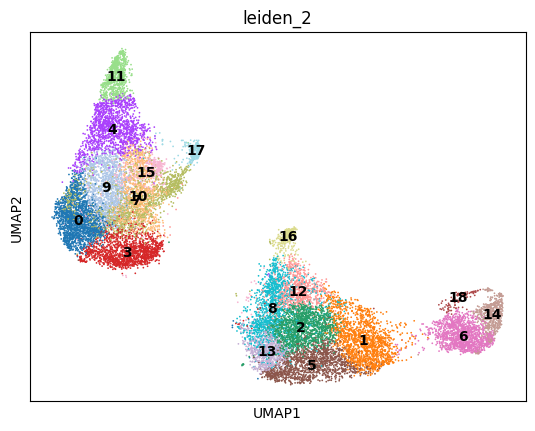

In [80]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Marker expression

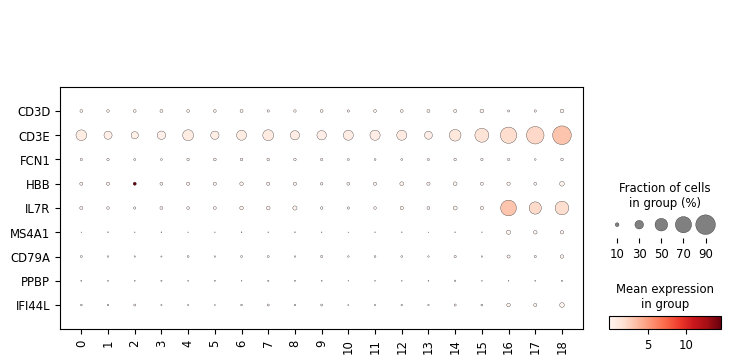

In [81]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

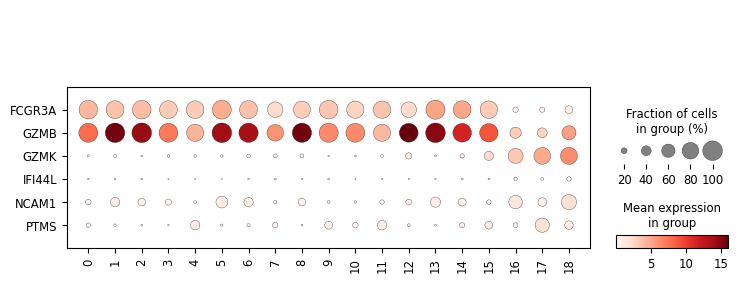

In [82]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = class_markers, swap_axes = True)

### Cluster counts

In [83]:
adata.obs['leiden_2'].value_counts()

leiden_2
0     1761
1     1590
2     1544
3     1534
4     1429
5     1382
6     1360
7     1293
8     1284
9     1170
10     908
11     752
12     701
13     686
14     585
15     532
16     310
17     234
18     112
Name: count, dtype: int64

### Comparison to original labels

In [84]:
adata = add_labels(adata, original_df)

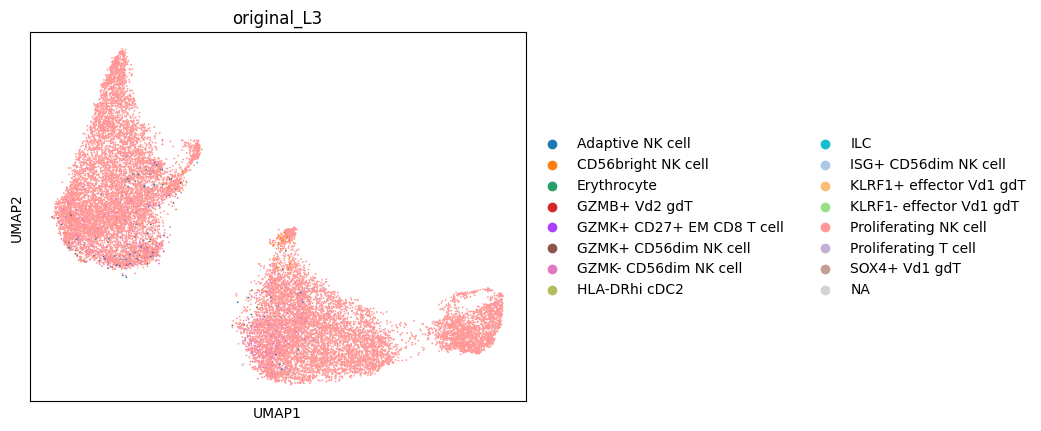

In [85]:
sc.pl.umap(adata, color = 'original_L3')

In [86]:
adata.obs['original_L3'].value_counts(dropna = False)

original_L3
Proliferating NK cell        18156
GZMK- CD56dim NK cell          488
Proliferating T cell           128
Adaptive NK cell               100
NaN                             96
CD56bright NK cell              84
GZMK+ CD56dim NK cell           70
ISG+ CD56dim NK cell            29
KLRF1+ effector Vd1 gdT          6
Erythrocyte                      2
GZMK+ CD27+ EM CD8 T cell        2
ILC                              2
GZMB+ Vd2 gdT                    1
HLA-DRhi cDC2                    1
KLRF1- effector Vd1 gdT          1
SOX4+ Vd1 gdT                    1
Name: count, dtype: int64

In [87]:
adata.obs['original_L3'].value_counts(dropna = False) / adata.obs.shape[0]

original_L3
Proliferating NK cell        0.947253
GZMK- CD56dim NK cell        0.025460
Proliferating T cell         0.006678
Adaptive NK cell             0.005217
NaN                          0.005009
CD56bright NK cell           0.004383
GZMK+ CD56dim NK cell        0.003652
ISG+ CD56dim NK cell         0.001513
KLRF1+ effector Vd1 gdT      0.000313
Erythrocyte                  0.000104
GZMK+ CD27+ EM CD8 T cell    0.000104
ILC                          0.000104
GZMB+ Vd2 gdT                0.000052
HLA-DRhi cDC2                0.000052
KLRF1- effector Vd1 gdT      0.000052
SOX4+ Vd1 gdT                0.000052
Name: count, dtype: float64

## Review ILC

In [88]:
cell_type = 'ILC'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [89]:
type_uuid

'6304ced3-eaa4-4965-9836-0a2a3a039a00'

In [90]:
adata = read_adata_uuid(type_uuid)

### Clustering

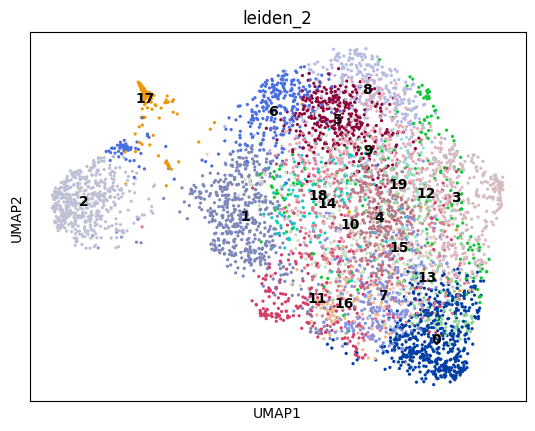

In [91]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Marker expression

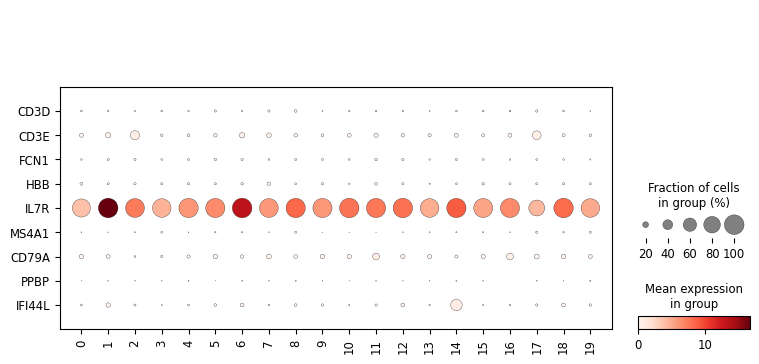

In [92]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

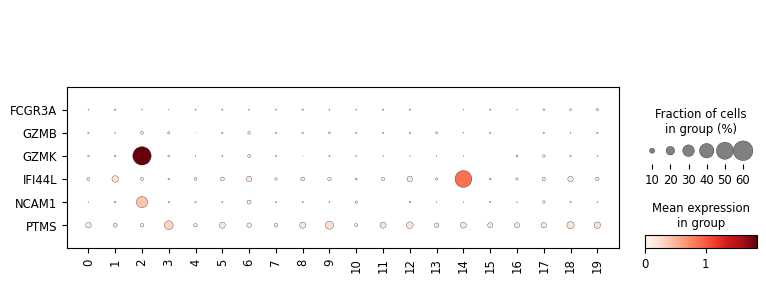

In [93]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = class_markers, swap_axes = True)

### Comparison to original labels

In [94]:
adata = add_labels(adata, original_df)

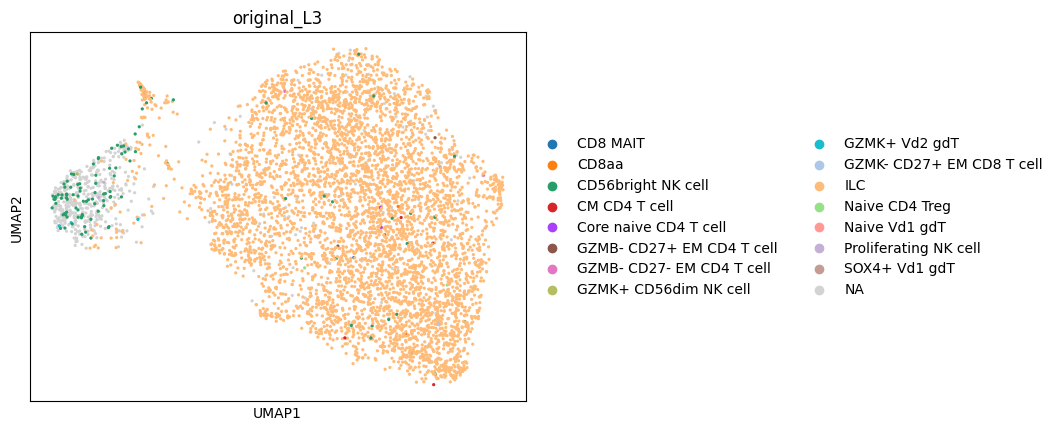

In [95]:
sc.pl.umap(adata, color = 'original_L3')

In [96]:
adata.obs['original_L3'].value_counts(dropna = False)

original_L3
ILC                          4846
NaN                           545
CD56bright NK cell            114
CM CD4 T cell                   5
SOX4+ Vd1 gdT                   4
GZMB- CD27+ EM CD4 T cell       3
GZMK+ Vd2 gdT                   3
Core naive CD4 T cell           2
GZMB- CD27- EM CD4 T cell       2
Naive CD4 Treg                  2
Proliferating NK cell           2
CD8 MAIT                        1
CD8aa                           1
GZMK+ CD56dim NK cell           1
GZMK- CD27+ EM CD8 T cell       1
Naive Vd1 gdT                   1
Name: count, dtype: int64

In [97]:
adata.obs['original_L3'].value_counts(dropna = False) / adata.obs.shape[0]

original_L3
ILC                          0.875836
NaN                          0.098500
CD56bright NK cell           0.020604
CM CD4 T cell                0.000904
SOX4+ Vd1 gdT                0.000723
GZMB- CD27+ EM CD4 T cell    0.000542
GZMK+ Vd2 gdT                0.000542
Core naive CD4 T cell        0.000361
GZMB- CD27- EM CD4 T cell    0.000361
Naive CD4 Treg               0.000361
Proliferating NK cell        0.000361
CD8 MAIT                     0.000181
CD8aa                        0.000181
GZMK+ CD56dim NK cell        0.000181
GZMK- CD27+ EM CD8 T cell    0.000181
Naive Vd1 gdT                0.000181
Name: count, dtype: float64

In [101]:
os.system('jupyter nbconvert --to html --template pj 13f-Python_review_filtered_L3_nk_data.ipynb')

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook 13f-Python_review_filtered_L3_nk_data.ipynb to html
[NbConvertApp] Writing 10973889 bytes to 13f-Python_review_filtered_L3_nk_data.html


0

In [99]:
import session_info
session_info.show()